# Pytest Interactive Tutorial

This notebook helps you understand pytest concepts interactively.

## Part 1: Understanding Fixtures

Fixtures are reusable pieces of test data. Let's see how they work.

In [2]:
# First, let's look at what our fixtures create
# Note: Fixtures are designed for pytest, not direct calls
# So we'll create regular versions to demonstrate

import numpy as np
import xarray as xr
from datetime import datetime, timedelta

def create_sample_bbox():
    """Sample bounding box for Berlin area."""
    return (13.0, 52.0, 14.0, 53.0)

def create_sample_sar_data():
    """Create sample SAR data for testing."""
    np.random.seed(42)
    
    # Dimensions
    times = [datetime(2022, 1, 1) + timedelta(days=i*10) for i in range(3)]
    x = np.arange(100)
    y = np.arange(100)
    
    # Create data with some spatial structure
    data_values = np.random.gamma(2, 0.5, (3, 100, 100))
    
    # Create DataArray
    data = xr.DataArray(
        data_values,
        coords={"time": times, "y": y, "x": x},
        dims=["time", "y", "x"],
        name="vv",
    )
    
    return data

# Create instances
bbox = create_sample_bbox()
print(f"Sample bbox: {bbox}")
print(f"Type: {type(bbox)}")
print(f"Values: min_lon={bbox[0]}, min_lat={bbox[1]}, max_lon={bbox[2]}, max_lat={bbox[3]}")

print("\n💡 In actual tests, pytest automatically calls fixtures!")
print("   You just add them as function parameters:")
print("   def test_something(sample_bbox):  # ← pytest injects this automatically")


Sample bbox: (13.0, 52.0, 14.0, 53.0)
Type: <class 'tuple'>
Values: min_lon=13.0, min_lat=52.0, max_lon=14.0, max_lat=53.0

💡 In actual tests, pytest automatically calls fixtures!
   You just add them as function parameters:
   def test_something(sample_bbox):  # ← pytest injects this automatically


In [3]:
# Let's see what sample_sar_data creates
sar_data = create_sample_sar_data()
print(f"SAR Data shape: {sar_data.shape}")
print(f"Dimensions: {sar_data.dims}")
print(f"Coordinates: {list(sar_data.coords)}")
print(f"\nTime steps: {len(sar_data.time)}")
print(f"Spatial size: {sar_data.shape[1]} x {sar_data.shape[2]}")
print(f"\nData range: {float(sar_data.min()):.3f} to {float(sar_data.max()):.3f}")


SAR Data shape: (3, 100, 100)
Dimensions: ('time', 'y', 'x')
Coordinates: ['time', 'y', 'x']

Time steps: 3
Spatial size: 100 x 100

Data range: 0.003 to 6.847


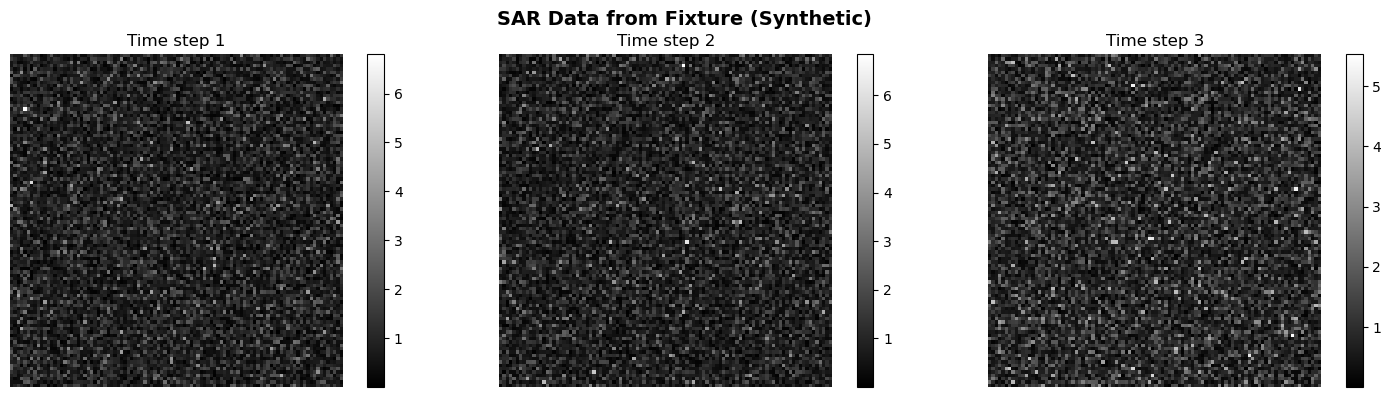

This is the data our tests use!
Notice it's randomly generated but REPRODUCIBLE (same every time due to np.random.seed(42))


In [4]:
# Visualize the fixture data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    im = ax.imshow(sar_data.isel(time=i), cmap='gray')
    ax.set_title(f'Time step {i+1}')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.suptitle('SAR Data from Fixture (Synthetic)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("This is the data our tests use!")
print("Notice it's randomly generated but REPRODUCIBLE (same every time due to np.random.seed(42))")


## Part 2: Understanding Mocking

Mocking replaces real objects with fake ones. Let's see how it works.

In [5]:
from unittest.mock import Mock

# Create a simple mock
mock_stac_item = Mock()

# Set some attributes
mock_stac_item.id = "S1A_IW_GRDH_TEST"
mock_stac_item.datetime = "2022-01-01T12:00:00Z"
mock_stac_item.bbox = [13.0, 52.0, 14.0, 53.0]

# Access them
print(f"Item ID: {mock_stac_item.id}")
print(f"DateTime: {mock_stac_item.datetime}")
print(f"BBox: {mock_stac_item.bbox}")

# You can access ANY attribute on a mock (it creates them on the fly!)
print(f"\nUndefined attribute: {mock_stac_item.some_random_thing}")
print(f"Type of that: {type(mock_stac_item.some_random_thing)}")

Item ID: S1A_IW_GRDH_TEST
DateTime: 2022-01-01T12:00:00Z
BBox: [13.0, 52.0, 14.0, 53.0]

Undefined attribute: <Mock name='mock.some_random_thing' id='2096054647360'>
Type of that: <class 'unittest.mock.Mock'>


In [6]:
# Mock methods with return values
mock_search_result = Mock()
mock_search_result.items.return_value = ["item1", "item2", "item3"]

# Call the method
items = mock_search_result.items()
print(f"Items: {items}")

# You can check if it was called
print(f"\nWas items() called? {mock_search_result.items.called}")
print(f"How many times? {mock_search_result.items.call_count}")

Items: ['item1', 'item2', 'item3']

Was items() called? True
How many times? 1


In [7]:
# side_effect: Different value each time
mock_function = Mock()
mock_function.side_effect = [1, 2, 3, 4, 5]

print("Calling mock function 5 times:")
for i in range(5):
    result = mock_function()
    print(f"  Call {i+1}: {result}")

Calling mock function 5 times:
  Call 1: 1
  Call 2: 2
  Call 3: 3
  Call 4: 4
  Call 5: 5


In [8]:
# side_effect with exceptions
mock_api = Mock()
mock_api.fetch.side_effect = ConnectionError("API is down!")

try:
    mock_api.fetch()
except ConnectionError as e:
    print(f"Caught error: {e}")
    print("This is useful for testing error handling!")

Caught error: API is down!
This is useful for testing error handling!


## Part 3: Assertions in Pytest

Let's practice different types of assertions.

In [9]:
import numpy as np
import xarray as xr

# Basic assertions
value = 10
assert value == 10, "Simple equality"
assert value > 5, "Greater than"
assert value in [5, 10, 15], "Membership"
assert isinstance(value, int), "Type checking"

print("✅ All basic assertions passed!")

✅ All basic assertions passed!


In [10]:
# Floating point assertions (NEVER use == for floats!)
a = 0.1 + 0.1 + 0.1
b = 0.3

# This might fail!
try:
    assert a == b
    print("Exact equality worked")
except AssertionError:
    print(f"❌ Exact equality failed: {a} != {b}")
    print(f"   Difference: {abs(a - b)}")

# Use np.isclose or pytest.approx instead
assert np.isclose(a, b), "Close enough!"
print("✅ np.isclose() worked!")

❌ Exact equality failed: 0.30000000000000004 != 0.3
   Difference: 5.551115123125783e-17
✅ np.isclose() worked!


In [11]:
# Testing exceptions
import pytest

def divide(a, b):
    return a / b

# This is how you test that an exception is raised
with pytest.raises(ZeroDivisionError):
    divide(10, 0)

print("✅ Successfully caught the expected exception!")

✅ Successfully caught the expected exception!


In [12]:
# Array assertions
arr1 = np.array([1, 2, 3])
arr2 = np.array([1, 2, 3])

# Don't use == for arrays!
assert np.array_equal(arr1, arr2), "Arrays are equal"

# For floating point arrays
arr3 = np.array([1.0, 2.0, 3.0])
arr4 = np.array([1.0, 2.0, 3.0000001])
assert np.allclose(arr3, arr4, atol=1e-5), "Arrays are close enough"

print("✅ Array assertions passed!")

✅ Array assertions passed!


## Part 4: Running Actual Tests

Let's see how our actual test functions work.

In [13]:
# Let's run the actual test logic (without pytest framework)
# Create test data
before = xr.DataArray(np.ones((10, 10)))
after = xr.DataArray(np.ones((10, 10)) * 2)

# Import the function being tested
import sys
sys.path.append('..')
from sar_processing.change_detection import ChangeDetector

# Run the test logic
change = ChangeDetector.log_ratio(before, after)

print(f"Change (dB): {float(change.mean()):.4f}")
print(f"Expected: ~3.0103 dB (10*log10(2))")
print(f"Match? {np.allclose(change, 3.0103, atol=0.01)}")

# This is what happens inside test_log_ratio_increase() in the actual test file!
print("\n✅ Test passed! This is exactly what the pytest test does.")


Change (dB): 3.0103
Expected: ~3.0103 dB (10*log10(2))
Match? True

✅ Test passed! This is exactly what the pytest test does.


## Part 5: Practice Exercises

Try these yourself!

In [14]:
# Exercise 1: Create a fixture that returns a list of numbers
# Your code here:

def my_fixture():
    """Return a list of 10 random numbers."""
    np.random.seed(123)
    return np.random.rand(10)

# Test it:
data = my_fixture()
print(f"My fixture returns: {data}")
assert len(data) == 10, "Should return 10 numbers"
print("✅ Exercise 1 passed!")

My fixture returns: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897 0.42310646
 0.9807642  0.68482974 0.4809319  0.39211752]
✅ Exercise 1 passed!


In [15]:
# Exercise 2: Create a mock that returns different values
mock_sensor = Mock()
mock_sensor.read.side_effect = [20, 21, 22, 23, 24]  # Temperature readings

readings = [mock_sensor.read() for _ in range(5)]
print(f"Sensor readings: {readings}")
assert readings == [20, 21, 22, 23, 24]
print("✅ Exercise 2 passed!")

Sensor readings: [20, 21, 22, 23, 24]
✅ Exercise 2 passed!


In [16]:
# Exercise 3: Write a test for a simple function
def celsius_to_fahrenheit(celsius):
    """Convert Celsius to Fahrenheit."""
    return (celsius * 9/5) + 32

# Write assertions to test it:
assert celsius_to_fahrenheit(0) == 32, "Freezing point"
assert celsius_to_fahrenheit(100) == 212, "Boiling point"
assert np.isclose(celsius_to_fahrenheit(37), 98.6), "Body temperature"

print("✅ Exercise 3 passed!")

✅ Exercise 3 passed!


## Summary: Key Pytest Concepts

1. **Fixtures** - Reusable test data (use `@pytest.fixture`)
2. **Mocking** - Fake objects for testing (use `Mock()` and `@patch`)
3. **Assertions** - Check results (use `assert` and `pytest.raises()`)
4. **Parametrization** - Same test, different inputs (use `@pytest.mark.parametrize`)
5. **Test Discovery** - Files start with `test_`, functions start with `test_`

### Next Steps:
1. Read [PYTEST_GUIDE.md](../PYTEST_GUIDE.md) for complete reference
2. Study [test_parametrize_tutorial.py](../tests/test_parametrize_tutorial.py)
3. Run the actual tests: `pytest tests/ -v`
4. Experiment with your own tests!